In [ ]:
 #import necessary libraries
import os
import numpy as np
import cv2
import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Data
data_path = '/content/drive/MyDrive/data'

In [ ]:
#function for data loading
def load_and_process_data(data_path):
    images = []
    labels = []
    mat_files = [f for f in os.listdir(data_path) if f.endswith('.mat') and f != 'cvind.mat']
    for filename in mat_files:
        file_path = os.path.join(data_path, filename)
        try:
            with h5py.File(file_path, 'r') as f:
                cjdata = f['cjdata']
                image = np.array(cjdata['image']).T
                label = int(np.array(cjdata['label'])[0][0])
                image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
                image = cv2.resize(image, (128, 128))
                images.append(image)
                labels.append(label)
        except Exception as e:
            print(f"Error reading {filename}: {e}")
    return np.array(images), np.array(labels)

In [ ]:
# Load and preprocess data
images, labels = load_and_process_data(data_path)

# Adjust labels to be 0-indexed
labels = labels - 1

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Reshape data for CNN
X_train = X_train.reshape(X_train.shape[0], 128, 128, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 128, 1)


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile with lower learning rate
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.5024 - loss: 25.7139 - val_accuracy: 0.6957 - val_loss: 0.6944
Epoch 2/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6948 - loss: 0.6667 - val_accuracy: 0.7772 - val_loss: 0.5225
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7946 - loss: 0.5030 - val_accuracy: 0.7772 - val_loss: 0.4883
Epoch 4/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8142 - loss: 0.4341 - val_accuracy: 0.8043 - val_loss: 0.3900
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8505 - loss: 0.3727 - val_accuracy: 0.8261 - val_loss: 0.3712
Epoch 6/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8790 - loss: 0.2972 - val_accuracy: 0.8424 - val_loss: 0.3354
Epoch 7/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8854 - loss: 0.2757 - val_accuracy: 0.8641 - val_loss: 0.3386
Epoch 8/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8979 - loss: 0.2424 - val_accuracy: 0.8859 - 

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Test Loss: {loss:.4f}')

Test Accuracy: 91.74%
Test Loss: 0.2283


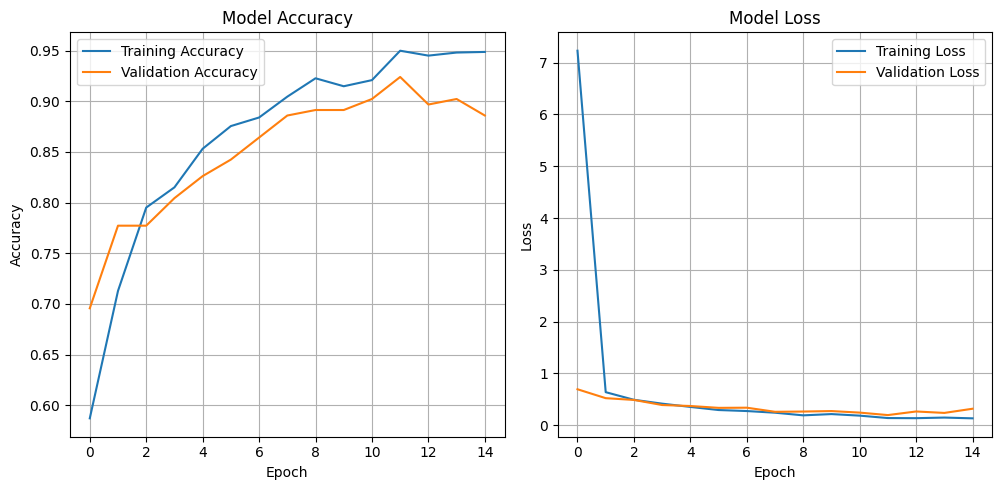

In [ ]:
# Plot training history
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
#Results
print(f"\nFinal Results:")
print(f"Training Accuracy: {max(history.history['accuracy']):.4f}")
print(f"Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Training Loss: {min(history.history['loss']):.4f}")
print(f"Validation Loss: {min(history.history['val_loss']):.4f}")
print(f"Test Loss: {loss:.4f}")

Improved model saved to Google Drive.

Final Results:
Training Accuracy: 0.9498
Validation Accuracy: 0.9239
Test Accuracy: 0.9174
Training Loss: 0.1331
Validation Loss: 0.1961
Test Loss: 0.2283
